# Simple regression with Gaussian processes

Le's take a simple analytical function, sample a few points, add some noise and try to extract a meaningful Gaussian process from it.

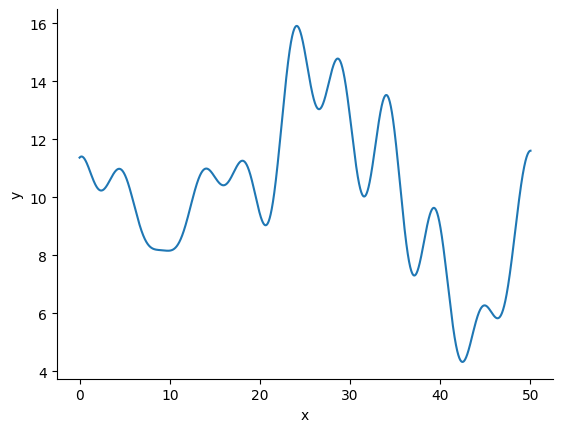

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def original_function(x, seed=1 , nterms=20):
    rng = np.random.default_rng(seed)
    cumulative_sum = 0
    for i in range(nterms):
        omega = rng.normal(0.1, 0.5)
        phi = rng.uniform(-1,1)

        cumulative_sum += np.sin(omega*x+phi)
    return  cumulative_sum+10

xlo, xhi = 0, 50

x = np.linspace(xlo, xhi,10000)

plt.plot(x, original_function(x))
plt.gca().set(xlabel="x", ylabel="y");

Now we take a small number of samples, no necessarily equally spaced, and use  it for **regression**

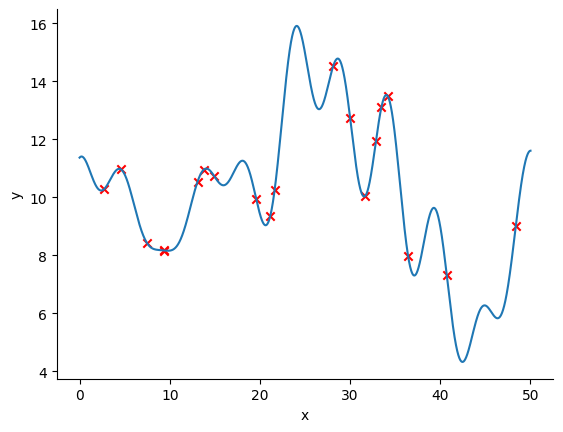

In [3]:
N = 20
rng = np.random.default_rng(seed=2)
xtrain =rng.uniform(xlo,xhi,N)
ytrain = original_function(xtrain)
plt.plot(x, original_function(x))
plt.scatter(xtrain, ytrain, marker='x', color='r')
plt.gca().set(xlabel="x", ylabel="y");

We use `sklearn` to perform the regression using a **Gaussian process**. We use the class `GaussianProcessRegressor`. By default it used a particular model for the correlations, i.e. a radial basis function which is just a Gaussian itslef.

Briefly , for $N$ observations $\mathbf{y} = \{y_0,\dots, y_{N-1}\}$ at locations $\mathbf{x} = \{x_0,\dots, x_{N-1}\}$ we want to predict the new values at $M$ locations $\mathbf{x}' = \{x'_0,\dots, x'_{M-1}\}$

The mean values will be estimates by the Guassian process as

$$\mathbf{\mu}= \mathbf{k}^T C^{-1}\mathbf{y}$$

where $C$ is the **covariance matrix** with elements 

$$\mathrm{C}[n, m]=k\left(\mathbf{x}_n, \mathbf{x}_m\right)$$

and the function $k(a,b)$ is the **kernel function**, which tells us how correlations decays at points $a$ and $b$.  Often, a Gaussian kernel is used, which means

$$k\left(\mathbf{x}_n, \mathbf{x}_m\right)=\exp \left(-\left\|\mathbf{x}_n-\mathbf{x}_m\right\|^2 / 2 L^2\right) $$

where $L$ is a **hyperparamter**. We could fix it or optimise it by choosing a suitable objective function. For Gaussian Processes (with noise-less data) such function is the log-marginal likelihood

$$I = \log p(y \mid x)=-\frac{1}{2} y^T C^{-1} y-\frac{1}{2} \log \left|C\right|-\frac{N}{2} \log 2 \pi$$

This is maximised by varying the parameters that determine teh entries of $C$.

Read more [here](https://towardsdatascience.com/gaussian-process-kernels-96bafb4dd63e) and [here](http://gaussianprocess.org/gpml/chapters/RW2.pdf)



{'k1': 8.61**2, 'k2': RBF(length_scale=2.57), 'k1__constant_value': 74.06266118823054, 'k1__constant_value_bounds': (1e-05, 100000.0), 'k2__length_scale': 2.571844797353974, 'k2__length_scale_bounds': (1e-05, 100000.0)}


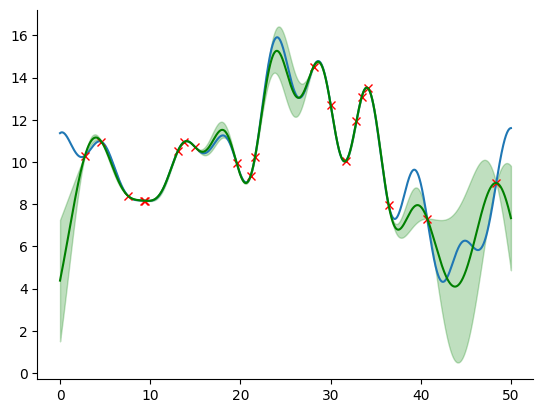

In [4]:

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Define a custom kernel: Constant Kernel multiplied by RBF Kernel
# - the scale of the constant jernel scales the variances and affects the estimate sof the uncertainty
# - the scale of the RBF refers to teh typical scale of the modulations of the target function
custom_kernel = C(1.0)* RBF(length_scale=2)

gp = GaussianProcessRegressor(
                              kernel=custom_kernel,
                              optimizer='fmin_l_bfgs_b',
                            #   n_restarts_optimizer=1,
                            #    optimizer=None
                               )
gp.fit(xtrain[:, np.newaxis], ytrain)
plt.plot(x,original_function(x))

# plt.ylim(original_function(x).min(),original_function(x).max())
# model
plt.plot(xtrain,ytrain,'rx')
mean, std = gp.predict(x[:,np.newaxis], return_std=True)
plt.fill_between(x,mean-std/2, mean+std/2, color='green', alpha=0.25)
plt.plot(x, mean,color='green')
print(gp.kernel_.get_params())

We can improve the estimates picking new points where uncretainty is large.

We start the optimser by **re-using** the values already optimised for the kernel

{'k1': 8.61**2, 'k2': RBF(length_scale=2.57), 'k1__constant_value': 74.06266118823054, 'k1__constant_value_bounds': (1e-05, 100000.0), 'k2__length_scale': 2.571844797353974, 'k2__length_scale_bounds': (1e-05, 100000.0)}


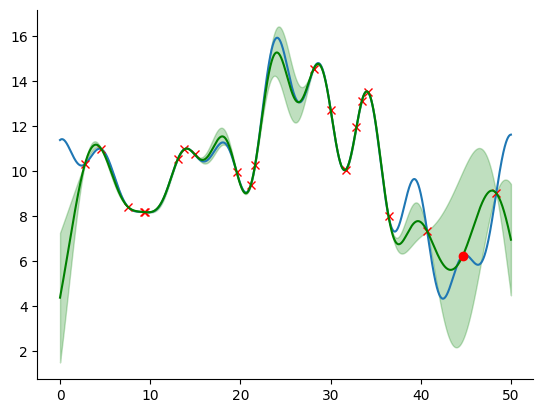

In [5]:
x_at_large_std = x[std.argmax()]
y_at_large_std = original_function(x)[std.argmax()]
new_xtrain =  np.concatenate((xtrain,[x_at_large_std]))
new_ytrain =  np.concatenate((ytrain,[y_at_large_std]))

custom_kernel.set_params(**(gp.kernel_.get_params()))
new_gp = GaussianProcessRegressor(
                              kernel=custom_kernel,
                              optimizer='fmin_l_bfgs_b'
)
new_gp.fit(new_xtrain[:, np.newaxis], new_ytrain)
plt.plot(x,original_function(x))


plt.plot(xtrain,ytrain,'rx')
new_mean, new_std = new_gp.predict(x[:,np.newaxis], return_std=True)
plt.fill_between(x,new_mean-std/2, new_mean+std/2, color='green', alpha=0.25)
plt.plot(x, new_mean,color='green')
plt.plot([x_at_large_std],[y_at_large_std],'ro')
print(gp.kernel_.get_params())

We can do this iteratively to improve the model with some more points. Suppose we want to half the maximal standard deviation: we can proceed adding estimnates until this happens

Counter 1 23 3.7422691543110322 2.7040392496509416
{'k1': 8.36**2, 'k2': RBF(length_scale=2.56), 'k1__constant_value': 69.95460011196583, 'k1__constant_value_bounds': (1e-05, 100000.0), 'k2__length_scale': 2.5639552430463826, 'k2__length_scale_bounds': (1e-05, 100000.0)}


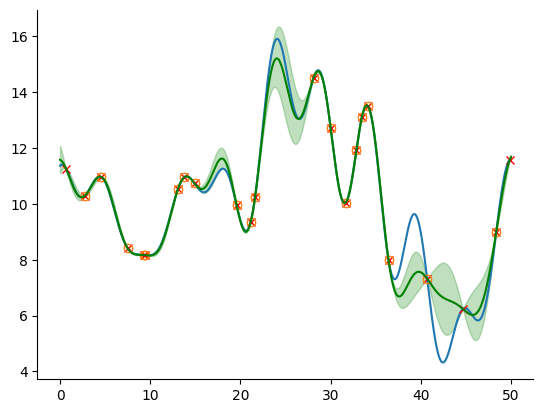

In [6]:
original_max_std = std.max()
target_std = original_max_std*0.5
max_iter = 20
for i in range(max_iter):

    indices = np.where(new_std>target_std)[0]
    pick = np.random.choice(indices)
    x_at_large_std = x[pick]
    y_at_large_std = original_function(x)[pick]
    new_xtrain =  np.concatenate((new_xtrain,[x_at_large_std]))
    new_ytrain =  np.concatenate((new_ytrain,[y_at_large_std]))

    custom_kernel.set_params(**(new_gp.kernel_.get_params()))
    new_gp = GaussianProcessRegressor(
                                kernel=custom_kernel,
                                optimizer='fmin_l_bfgs_b'
    )
    new_gp.fit(new_xtrain[:, np.newaxis], new_ytrain)
    new_mean, new_std = new_gp.predict(x[:,np.newaxis], return_std=True)
    if new_std.max()<target_std:
        print("Counter",i,len(new_xtrain),target_std,new_std.max()  )
        break
    
plt.plot(x,original_function(x))
plt.plot(new_xtrain,new_ytrain,'rx')
plt.plot(xtrain,ytrain,'o', mfc="None")

plt.fill_between(x,new_mean-new_std/2, new_mean+new_std/2, color='green', alpha=0.25)
plt.plot(x, new_mean,color='green')
print(gp.kernel_.get_params())